In [3]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
exchange = ccxt.binance({
    'rateLimit': 1200,
    'enableRateLimit': True,
})
exchange.load_markets()

desired = [
    'BTC/USDT', 'ETH/USDT', 'BTC/USDC', 'ADA/USDC', 'ETH/DAI',
    'BNB/BUSD','XRP/USDT','DOT/USDC','BTC/DAI','UNI/BUSD'
]

symbols = [s for s in desired if s in exchange.symbols]
missing = set(desired) - set(symbols)
if missing:
    print("These pairs are not in Binance:", missing)

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import time

binance = ccxt.binance()
symbols = ['BUSD/USDT', 'USDC/USDT', 'TUSD/USDT', 'PAX/USDT', 'BUSD/USDT',
    'USDC/TUSD',
    # 'USDC/PAX', 'USDC/BUSD',
    
    'BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'BNB/USDT', 'XRP/USDT',
    'DOT/USDT', 'LTC/USDT', 'ETH/USDC', 'BTC/USDC', 'ADA/USDC',
    
    'ETH/BTC', 'ADA/BTC', 'ADA/ETH', 'BNB/ETH', 'DOT/BTC',
    'XRP/BTC', 'BNB/ETH', 'SOL/USDT', 'DOGE/BTC', 'AVAX/ETH']

timeframe = '1h'  # 1-часовой интервал

def get_ohlcv(symbol, since):
    ohlcv = []
    while True:
        data = binance.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if len(data) < 1000:
            ohlcv += data
            break
        ohlcv += data
        since = data[-1][0] + 1
        time.sleep(1)
    return ohlcv

def calculate_slope(df):
    X = np.arange(len(df)).reshape(-1, 1)
    y = np.log(df['close'].values)
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

def calculate_std(df):
    log_returns = np.diff(np.log(df['close'].values))
    return np.std(log_returns)

def convert_to_usdt(pair):
    if 'USDT' in pair:
        return 1
    
    base_currency, quote_currency = pair.split('/')
    
    if base_currency != 'USDT':
        base_to_usdt = binance.fetch_ticker(f'{base_currency}/USDT')['last']
        # print(f'{base_currency}/USDT: {base_to_usdt}\n')
    else:
        base_to_usdt = 1
        
    if quote_currency != 'USDT':
        quote_to_usdt = binance.fetch_ticker(f'{quote_currency}/USDT')['last']
        # print(f'{quote_currency}/USDT: {quote_to_usdt}\n')
    else:
        quote_to_usdt = 1
        
    return base_to_usdt / quote_to_usdt

stable_stable = [
    'BUSD/USDT', 'USDC/USDT', 'TUSD/USDT', 'PAX/USDT', 'BUSD/USDT',
    'USDC/TUSD',
    # 'USDC/PAX', 'USDC/BUSD'
    ]
stable_non_stable = [
    'BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'BNB/USDT', 'XRP/USDT',
    'DOT/USDT', 'LTC/USDT', 'ETH/USDC', 'BTC/USDC', 'ADA/USDC'
]
non_stable_non_stable = [
    'ETH/BTC', 'ADA/BTC', 'ADA/ETH', 'BNB/ETH', 'DOT/BTC',
    'XRP/BTC', 'BNB/ETH', 'SOL/USDT', 'DOGE/BTC', 'AVAX/ETH'
]

slopes_stable_stable = {}
std_devs_stable_stable = {}
slopes_stable_non_stable = {}
std_devs_stable_non_stable = {}
slopes_non_stable_non_stable = {}
std_devs_non_stable_non_stable = {}

for symbol in symbols:
    print(f"Получаем данные для {symbol}...")
    since = binance.parse8601('2024-05-06T00:00:00Z')

    ohlcv = get_ohlcv(symbol, since)
    df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    conversion_rate = convert_to_usdt(symbol)
    df['close'] = df['close'] * conversion_rate
    df['open'] = df['open'] * conversion_rate
    df['high'] = df['high'] * conversion_rate
    df['low'] = df['low'] * conversion_rate

    df['week'] = df['timestamp'].dt.to_period('W')

    for week, group in df.groupby('week'):
        slope = calculate_slope(group)
        std_dev = calculate_std(group)

        if symbol in stable_stable:
            slopes_stable_stable[(week, symbol)] = slope
            std_devs_stable_stable[(week, symbol)] = std_dev
        elif symbol in stable_non_stable:
            slopes_stable_non_stable[(week, symbol)] = slope
            std_devs_stable_non_stable[(week, symbol)] = std_dev
        elif symbol in non_stable_non_stable:
            slopes_non_stable_non_stable[(week, symbol)] = slope
            std_devs_non_stable_non_stable[(week, symbol)] = std_dev

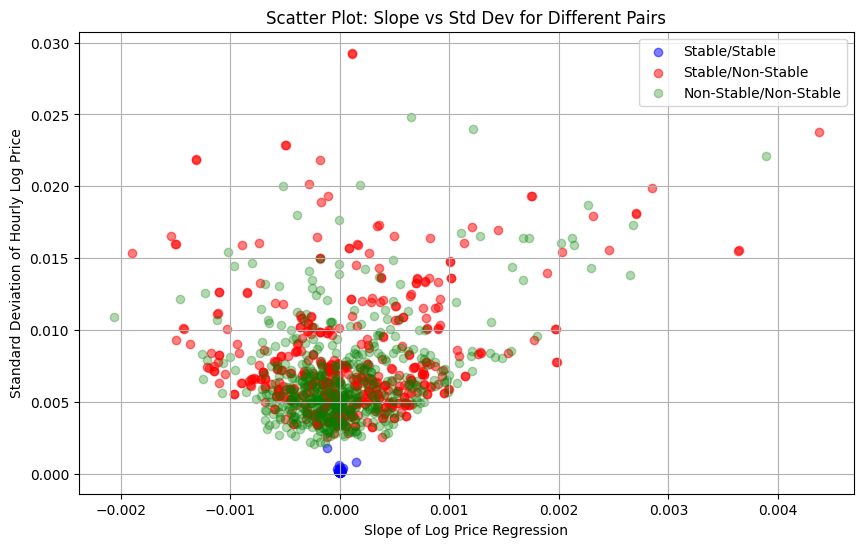

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(slopes_stable_stable.values(), std_devs_stable_stable.values(), color='blue', label='Stable/Stable', alpha=0.5)
plt.scatter(slopes_stable_non_stable.values(), std_devs_stable_non_stable.values(), color='red', label='Stable/Non-Stable', alpha=0.5)
plt.scatter(slopes_non_stable_non_stable.values(), std_devs_non_stable_non_stable.values(), color='green', label='Non-Stable/Non-Stable', alpha=0.3)

plt.xlabel('Slope of Log Price Regression')
plt.ylabel('Standard Deviation of Hourly Log Price')
plt.title('Scatter Plot: Slope vs Std Dev for Different Pairs')
plt.legend()
plt.grid(True)
plt.show()

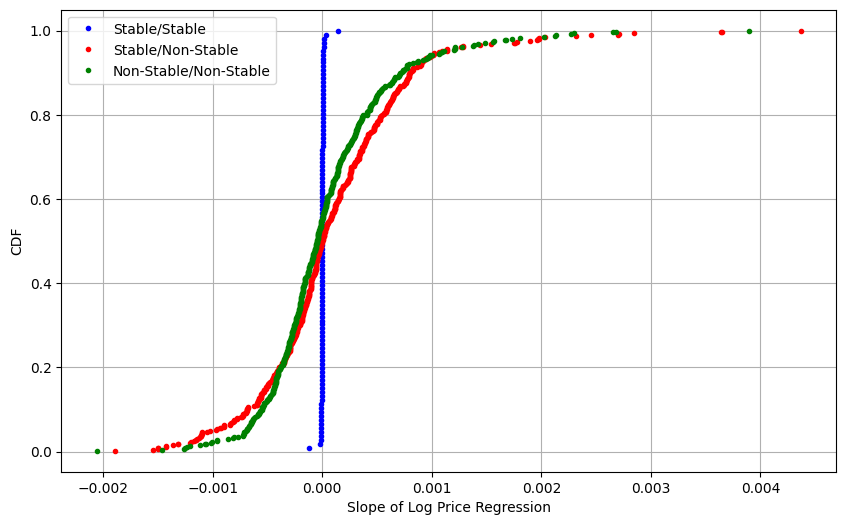

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sorted_slopes1 = np.sort(list(slopes_stable_non_stable.values()))
cdf1 = np.arange(1, len(sorted_slopes1) + 1) / len(sorted_slopes1)

sorted_slopes2 = np.sort(list(slopes_stable_stable.values()))
cdf2 = np.arange(1, len(sorted_slopes2) + 1) / len(sorted_slopes2)

sorted_slopes3 = np.sort(list(slopes_non_stable_non_stable.values()))
cdf3 = np.arange(1, len(sorted_slopes3) + 1) / len(sorted_slopes3)

plt.figure(figsize=(10, 6))
plt.plot(sorted_slopes2, cdf2, marker='.', linestyle='none', color='b', label='Stable/Stable')
plt.plot(sorted_slopes1, cdf1, marker='.', linestyle='none', color='red', label='Stable/Non-Stable')
plt.plot(sorted_slopes3, cdf3, marker='.', linestyle='none', color='g', label='Non-Stable/Non-Stable')

plt.xlabel('Slope of Log Price Regression')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


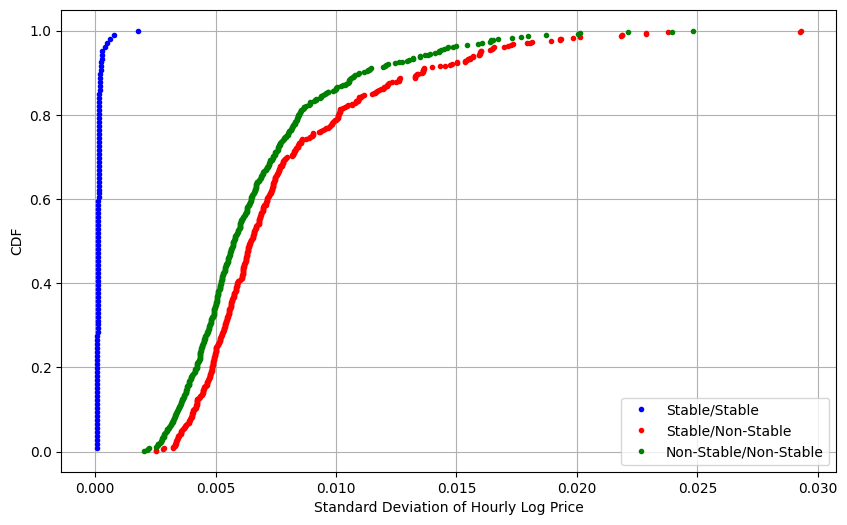

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sorted_slopes1 = np.sort(list(std_devs_stable_non_stable.values()))
cdf1 = np.arange(1, len(sorted_slopes1) + 1) / len(sorted_slopes1)

sorted_slopes2 = np.sort(list(std_devs_stable_stable.values()))
cdf2 = np.arange(1, len(sorted_slopes2) + 1) / len(sorted_slopes2)

sorted_slopes3 = np.sort(list(std_devs_non_stable_non_stable.values()))
cdf3 = np.arange(1, len(sorted_slopes3) + 1) / len(sorted_slopes3)

plt.figure(figsize=(10, 6))
plt.plot(sorted_slopes2, cdf2, marker='.', linestyle='none', color='b', label='Stable/Stable')
plt.plot(sorted_slopes1, cdf1, marker='.', linestyle='none', color='red', label='Stable/Non-Stable')
plt.plot(sorted_slopes3, cdf3, marker='.', linestyle='none', color='g', label='Non-Stable/Non-Stable')

plt.xlabel('Standard Deviation of Hourly Log Price')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
slopes_stable_non_stable

{(Period('2024-05-06/2024-05-12', 'W-SUN'),
  'BTC/USDT'): np.float64(-0.0003215198948079744),
 (Period('2024-05-13/2024-05-19', 'W-SUN'),
  'BTC/USDT'): np.float64(0.0006029028490065029),
 (Period('2024-05-20/2024-05-26', 'W-SUN'),
  'BTC/USDT'): np.float64(-2.5063843462255783e-05),
 (Period('2024-05-27/2024-06-02', 'W-SUN'),
  'BTC/USDT'): np.float64(-0.00010565081908620456),
 (Period('2024-06-03/2024-06-09', 'W-SUN'),
  'BTC/USDT'): np.float64(1.7441336917532286e-05),
 (Period('2024-06-10/2024-06-16', 'W-SUN'),
  'BTC/USDT'): np.float64(-0.00029572973938887136),
 (Period('2024-06-17/2024-06-23', 'W-SUN'),
  'BTC/USDT'): np.float64(-0.0002020910028203496),
 (Period('2024-06-24/2024-06-30', 'W-SUN'),
  'BTC/USDT'): np.float64(-1.66588886856797e-05),
 (Period('2024-07-01/2024-07-07', 'W-SUN'),
  'BTC/USDT'): np.float64(-0.0008173571329563857),
 (Period('2024-07-08/2024-07-14', 'W-SUN'),
  'BTC/USDT'): np.float64(0.00033087875310526993),
 (Period('2024-07-15/2024-07-21', 'W-SUN'),
  'BT

In [93]:
std_devs_stable_non_stable

{(Period('2024-05-06/2024-05-12', 'W-SUN'),
  'BTC/USDT'): np.float64(0.004842818158332772),
 (Period('2024-05-13/2024-05-19', 'W-SUN'),
  'BTC/USDT'): np.float64(0.0040222409363540644),
 (Period('2024-05-20/2024-05-26', 'W-SUN'),
  'BTC/USDT'): np.float64(0.004695687369833176),
 (Period('2024-05-27/2024-06-02', 'W-SUN'),
  'BTC/USDT'): np.float64(0.003576385811114847),
 (Period('2024-06-03/2024-06-09', 'W-SUN'),
  'BTC/USDT'): np.float64(0.003479340973569932),
 (Period('2024-06-10/2024-06-16', 'W-SUN'),
  'BTC/USDT'): np.float64(0.0042299642105218934),
 (Period('2024-06-17/2024-06-23', 'W-SUN'),
  'BTC/USDT'): np.float64(0.0034199405699543227),
 (Period('2024-06-24/2024-06-30', 'W-SUN'),
  'BTC/USDT'): np.float64(0.004451311027898037),
 (Period('2024-07-01/2024-07-07', 'W-SUN'),
  'BTC/USDT'): np.float64(0.006167078023775122),
 (Period('2024-07-08/2024-07-14', 'W-SUN'),
  'BTC/USDT'): np.float64(0.0058679836550980325),
 (Period('2024-07-15/2024-07-21', 'W-SUN'),
  'BTC/USDT'): np.floa

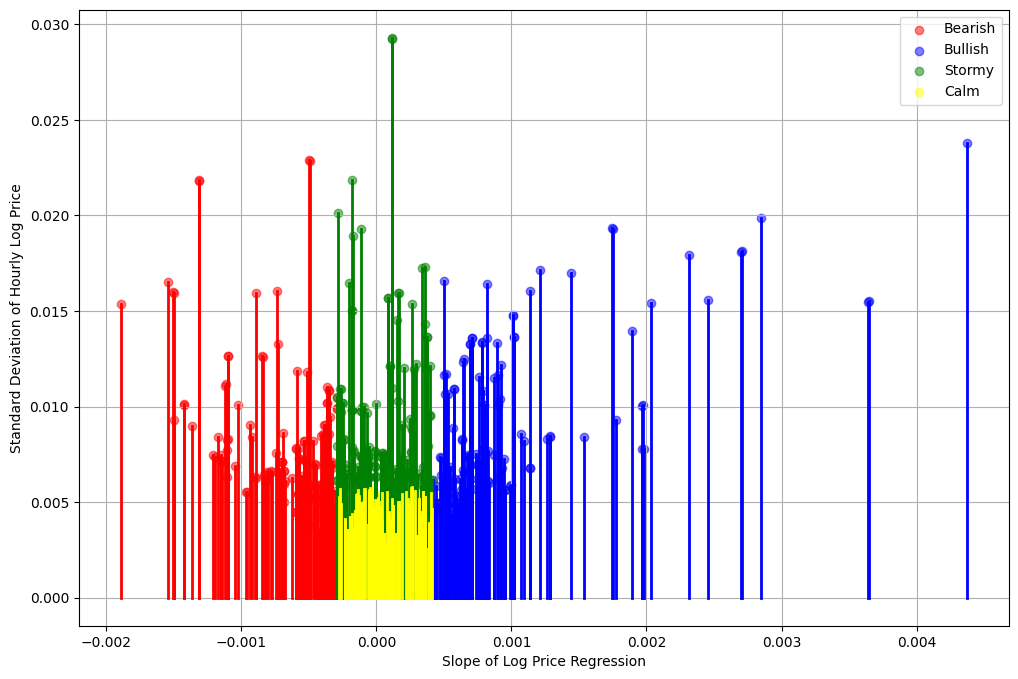

In [ ]:
def dict_to_df(data_dict, value_name):
    keys = list(data_dict.keys())
    values = list(data_dict.values())
    periods, pairs = zip(*keys)
    
    df = pd.DataFrame({
        'Period': periods,
        'Pair': pairs,
        value_name: values
    })
    return df

slopes_df = dict_to_df(slopes_stable_non_stable, 'Slope')
std_devs_df = dict_to_df(std_devs_stable_non_stable, 'Std_dev')
df = pd.merge(slopes_df, std_devs_df, on=['Period', 'Pair'])

df_sorted_slope = df.sort_values(by='Slope')
n = len(df_sorted_slope)
bearish = df_sorted_slope.iloc[:n//4]
bullish = df_sorted_slope.iloc[-n//4:]
remaining = df_sorted_slope.iloc[n//4: -n//4]

remaining_sorted_std = remaining.sort_values(by='Std_dev')
calm = remaining_sorted_std.iloc[:len(remaining_sorted_std)//2]
stormy = remaining_sorted_std.iloc[len(remaining_sorted_std)//2:]

plt.figure(figsize=(12, 8))
plt.scatter(bearish['Slope'], bearish['Std_dev'], color='red', label='Bearish', alpha=0.5)
for index, row in bearish.iterrows():
    plt.plot([row['Slope'], row['Slope']], [0, row['Std_dev']], color='red', linewidth=2)

plt.scatter(bullish['Slope'], bullish['Std_dev'], color='blue', label='Bullish', alpha=0.5)
for index, row in bullish.iterrows():
    plt.plot([row['Slope'], row['Slope']], [0, row['Std_dev']], color='blue', linewidth=2)

plt.scatter(stormy['Slope'], stormy['Std_dev'], color='green', label='Stormy', alpha=0.5)
for index, row in stormy.iterrows():
    plt.plot([row['Slope'], row['Slope']], [0, row['Std_dev']], color='green', linewidth=2)

plt.scatter(calm['Slope'], calm['Std_dev'], color='yellow', label='Calm', alpha=0.5)
for index, row in calm.iterrows():
    plt.plot([row['Slope'], row['Slope']], [0, row['Std_dev']], color='yellow', linewidth=2)

plt.xlabel('Slope of Log Price Regression')
plt.ylabel('Standard Deviation of Hourly Log Price')
plt.legend()
plt.grid(True)
plt.show()